In [49]:
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math
from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna

# Simple Regression Problem

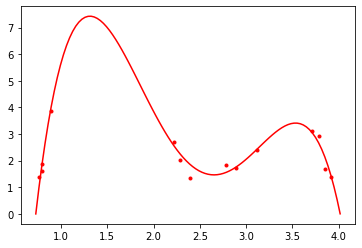

In [74]:
rng = np.random.default_rng(seed=1354)
N = 100
exp_er = 0.2 #10
# def truef(x):
#     return x**2+1
def truef(x):
    a,b,c,d,e,f = -1.6,1.8,-6,0,2.4,2.5
    return -(e*(x-f)**4+d*(x-f)**3+c*(x-f)**2+b*(x-f)+a)
x = np.linspace(0.729,4.015,N) #(1,10,10)
y = truef(x)
xd_indicies = [int(1*(N/100)),int(2*(N/100)),int(2.5*(N/100)),int(5*(N/100)),int(45*(N/100)),int(47*(N/100)),int(50*(N/100)),int(62*(N/100)),int(65*(N/100)),int(72*(N/100)),int(90*(N/100)),int(92*(N/100)),int(94*(N/100)),int(96*(N/100))]
# xd_indicies = np.linspace(0,N-1,20).astype(int)
# xd_indicies = range(N)
xd = x[xd_indicies]
M = len(xd)
yd = rng.normal(loc=truef(xd),scale=exp_er)

figSRP = plt.figure()
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.show()

prior_mean_vector = np.repeat(4,N)

In [105]:
#These are necessary to avoid 0 and infinities from inv and det of large matracies
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

# Gaussian Process Regression 3
See notes, uses bayes theorum and the prediction can have many x values. Also applicable to interferometry. 

      fun: 5.962765592720789
 hess_inv: array([[8.18680853, 0.50784315],
       [0.50784315, 0.04750419]])
      jac: array([1.43051147e-06, 4.58955765e-06])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([4.48691592, 0.35193642])
best Marge Li 5.962765592720789


Not good if zero, as need to be inverted.


K [[20.1324145  20.04307637 19.77743364 19.3424965 ]
 [20.04307637 20.1324145  20.04307637 19.77743364]
 [19.77743364 20.04307637 20.1324145  20.04307637]
 [19.3424965  19.77743364 20.04307637 20.1324145 ]]
The Determinent of K is: 0.0
The Determinent of cov_li is: 1.6384000000000116e-10
The Determinent of cov_post3 is: 0.0


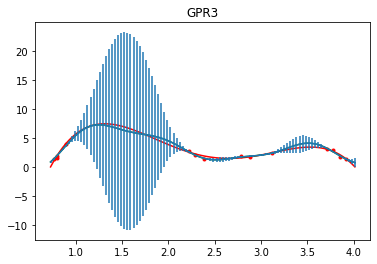

In [107]:
##Prior
mu_prior = prior_mean_vector
#exponential square kernel
def Kernel(x1,x2,params):
    x1 = x1
    x2 = x2
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    X1, X2 = np.meshgrid(x,x)
    #covergence matrix of Prior
    K = Kernel(X1,X2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,len(xd)))
    #R is a matrix that can take a potential function vector f_N and only return M values corresponding to f(x_1)...f(x_M) 
    R = np.zeros((M,N))
    for i in range(M):
        R[i,xd_indicies[i]]=1
    return K, R, cov_li


def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
#     try:
#         L = np.linalg.cholesky(test_matrix)
#     except np.linalg.LinAlgError:
#         return 1.7e307
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                
    
x0=[2.6,0.094]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=100)
print(results)
best_params = results.x
# best_params = x0
print('best Marge Li', MargLi(best_params))

#little data
# best_params = (7.4,0.7)
# print('margi LI',MargLi(*best_params,exp_er))

# print('best Params',best_params)
# print('loggli',best_margli)


def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (yd - R @ mu_prior)
    error_bars3 = np.diagonal(cov_post3)

    print('\n\nNot good if zero, as need to be inverted.')
    print('\n\nK',K[:4,:4])
    print('The Determinent of K is:', np.linalg.det(K))
    print('The Determinent of cov_li is:', np.linalg.det(cov_li))
    print('The Determinent of cov_post3 is:', np.linalg.det(cov_post3))

    figGPR3 = plt.figure()
    plt.title('GPR3')
    plt.plot(x,y,'r')
    plt.plot(xd,yd,'r.')
    plt.plot(x,mu_post3,'g')
    
    plt.errorbar(x, mu_post3, yerr=error_bars3)
    plt.show()

PlotBest(best_params, exp_er)


In [99]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 20)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

[I 2023-07-24 15:45:05,418] A new study created in memory with name: no-name-388f2bb5-01f1-4f6f-9e46-65e99b33248b
[I 2023-07-24 15:45:05,435] Trial 0 finished with value: 1.7e+307 and parameters: {'amp': 5.456320640649008, 'l': 3.568782807525885}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:05,446] Trial 1 finished with value: 1.7e+307 and parameters: {'amp': 14.973489915749001, 'l': 2.090835516092692}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:05,453] Trial 2 finished with value: 1.7e+307 and parameters: {'amp': 11.226267823564683, 'l': 3.9342242998306}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:05,458] Trial 3 finished with value: 1.7e+307 and parameters: {'amp': 3.68000737179657, 'l': 3.5420683722079835}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:05,462] Trial 4 finished with value: 1.7e+307 and parameters: {'amp': 16.897761007247013, 'l': 3.7843543237104127}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:05,4

[I 2023-07-24 15:45:06,972] Trial 47 finished with value: 1.7e+307 and parameters: {'amp': 15.014581857393472, 'l': 1.6243969549471395}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:07,013] Trial 48 finished with value: 1.7e+307 and parameters: {'amp': 17.04481878151022, 'l': 3.3956845451537268}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:07,051] Trial 49 finished with value: 1.7e+307 and parameters: {'amp': 13.391671712561182, 'l': 0.6617899789608233}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:07,091] Trial 50 finished with value: 1.7e+307 and parameters: {'amp': 8.790157043362688, 'l': 3.997912037693785}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:45:07,131] Trial 51 finished with value: 9.96314270190101 and parameters: {'amp': 5.858459234069144, 'l': 0.09349837512911674}. Best is trial 51 with value: 9.96314270190101.
[I 2023-07-24 15:45:07,178] Trial 52 finished with value: 1.7e+307 and parameters: {'amp': 12.217306343404616, 

[I 2023-07-24 15:45:09,006] Trial 92 finished with value: 1.7e+307 and parameters: {'amp': 3.9136282822972848, 'l': 0.21270044606286645}. Best is trial 89 with value: 8.142448898508635.
[I 2023-07-24 15:45:09,049] Trial 93 finished with value: 1.7e+307 and parameters: {'amp': 4.147849251459509, 'l': 0.3015717198764244}. Best is trial 89 with value: 8.142448898508635.
[I 2023-07-24 15:45:09,092] Trial 94 finished with value: 8.030356233229487 and parameters: {'amp': 3.37607115200782, 'l': 0.08974679006767244}. Best is trial 94 with value: 8.030356233229487.
[I 2023-07-24 15:45:09,133] Trial 95 finished with value: 1.7e+307 and parameters: {'amp': 2.1696725494440745, 'l': 0.48122970623656525}. Best is trial 94 with value: 8.030356233229487.
[I 2023-07-24 15:45:09,173] Trial 96 finished with value: 1.7e+307 and parameters: {'amp': 2.7328661825471916, 'l': 0.19397219582131775}. Best is trial 94 with value: 8.030356233229487.
[I 2023-07-24 15:45:09,214] Trial 97 finished with value: 1.7e+30

[I 2023-07-24 15:45:10,916] Trial 136 finished with value: 1.7e+307 and parameters: {'amp': 2.101931181482713, 'l': 0.16194883114888758}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:10,965] Trial 137 finished with value: 8.2281534911771 and parameters: {'amp': 2.4953527937758535, 'l': 0.07779397473690744}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:11,006] Trial 138 finished with value: 1.7e+307 and parameters: {'amp': 1.785205124203082, 'l': 0.25026914595923877}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:11,049] Trial 139 finished with value: 1.7e+307 and parameters: {'amp': 2.405568351845085, 'l': 0.40209518385488996}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:11,092] Trial 140 finished with value: 10.740968369947325 and parameters: {'amp': 3.13129565631765, 'l': 0.003577701713148085}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:11,135] Trial 141 finished 

[I 2023-07-24 15:45:13,093] Trial 179 finished with value: 9.007741279670135 and parameters: {'amp': 4.155249873735164, 'l': 0.07933129130621142}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:13,143] Trial 180 finished with value: 1.7e+307 and parameters: {'amp': 2.352964187186468, 'l': 0.22629431541794365}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:13,199] Trial 181 finished with value: 10.787273719864418 and parameters: {'amp': 3.5083794735757556, 'l': 0.0012008438510167085}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:13,254] Trial 182 finished with value: 8.705333768705557 and parameters: {'amp': 3.388806028173523, 'l': 0.07156219832092979}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:13,299] Trial 183 finished with value: 1.7e+307 and parameters: {'amp': 3.715770856003167, 'l': 0.11923790475301314}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:13,345] Trial 

[I 2023-07-24 15:45:15,282] Trial 222 finished with value: 1.7e+307 and parameters: {'amp': 3.0959983049654825, 'l': 0.11574484375784988}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:15,336] Trial 223 finished with value: 10.913210963359706 and parameters: {'amp': 2.7305546194940664, 'l': 0.0009204124653241497}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:15,388] Trial 224 finished with value: 1.7e+307 and parameters: {'amp': 3.3241587610579355, 'l': 0.19472493416462497}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:15,451] Trial 225 finished with value: 1.7e+307 and parameters: {'amp': 2.1832743583893817, 'l': 1.692294546404996}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:15,524] Trial 226 finished with value: 8.540034289719358 and parameters: {'amp': 2.9898252121057887, 'l': 0.07038137742881433}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:15,577] Trial 227 fin

[I 2023-07-24 15:45:17,534] Trial 265 finished with value: 1.7e+307 and parameters: {'amp': 1.372286640903007, 'l': 0.19620476100530865}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:17,585] Trial 266 finished with value: 1.7e+307 and parameters: {'amp': 3.362192193628561, 'l': 0.294447678625931}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:17,639] Trial 267 finished with value: 8.229605414819325 and parameters: {'amp': 2.5390557811373444, 'l': 0.07733477028667679}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:17,690] Trial 268 finished with value: 1.7e+307 and parameters: {'amp': 2.2699510175739492, 'l': 1.2147804655618466}. Best is trial 102 with value: 7.722049667808357.
[I 2023-07-24 15:45:17,741] Trial 269 finished with value: 7.668966691017287 and parameters: {'amp': 2.6029792830447396, 'l': 0.09426752825580886}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:17,791] Trial 270 finished 

[I 2023-07-24 15:45:19,888] Trial 309 finished with value: 9.660528449928343 and parameters: {'amp': 4.22593470199712, 'l': 0.06464222092756944}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:19,947] Trial 310 finished with value: 1.7e+307 and parameters: {'amp': 18.958118752918466, 'l': 0.24266334698197575}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:20,006] Trial 311 finished with value: 1.7e+307 and parameters: {'amp': 2.3640385765387832, 'l': 0.35147653566651194}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:20,069] Trial 312 finished with value: 16.21665674910764 and parameters: {'amp': 14.388365509138916, 'l': 0.06773276100108264}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:20,135] Trial 313 finished with value: 10.760609321755222 and parameters: {'amp': 3.017701873297257, 'l': 0.0038320259790916855}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:20,206] Trial

[I 2023-07-24 15:45:22,321] Trial 353 finished with value: 1.7e+307 and parameters: {'amp': 2.408713512749361, 'l': 0.12476016522818095}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:22,390] Trial 354 finished with value: 1.7e+307 and parameters: {'amp': 5.0412919449463995, 'l': 0.7381694244935804}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:22,460] Trial 355 finished with value: 1.7e+307 and parameters: {'amp': 2.9297166643038013, 'l': 0.4493063356852695}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:22,520] Trial 356 finished with value: 12.41158505937544 and parameters: {'amp': 2.046380017711808, 'l': 0.004076842101740197}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:22,578] Trial 357 finished with value: 1.7e+307 and parameters: {'amp': 3.6306081931773715, 'l': 2.0127530641227547}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:22,633] Trial 358 finished with val

[I 2023-07-24 15:45:24,912] Trial 397 finished with value: 1.7e+307 and parameters: {'amp': 2.8516451556099773, 'l': 3.5016404762004933}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:24,966] Trial 398 finished with value: 1.7e+307 and parameters: {'amp': 7.839405905663985, 'l': 2.7254085488996793}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:25,021] Trial 399 finished with value: 1.7e+307 and parameters: {'amp': 19.814213208330965, 'l': 0.1285627102696837}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:25,077] Trial 400 finished with value: 12.441874720850201 and parameters: {'amp': 2.039218494004289, 'l': 0.00683801481039463}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:25,132] Trial 401 finished with value: 1.7e+307 and parameters: {'amp': 3.418889707788279, 'l': 0.7474655068359362}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:25,186] Trial 402 finished with value

[I 2023-07-24 15:45:27,517] Trial 441 finished with value: 1.7e+307 and parameters: {'amp': 10.627167786410585, 'l': 0.11543601303051446}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:27,582] Trial 442 finished with value: 1.7e+307 and parameters: {'amp': 2.934873354745247, 'l': 2.81205102855749}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:27,645] Trial 443 finished with value: 1.7e+307 and parameters: {'amp': 0.8503594745021417, 'l': 0.23164533968012466}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:27,708] Trial 444 finished with value: 1.7e+307 and parameters: {'amp': 2.21010106531475, 'l': 3.3396711552032574}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:27,777] Trial 445 finished with value: 1.7e+307 and parameters: {'amp': 4.983435270169389, 'l': 0.820984936531922}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:27,848] Trial 446 finished with value: 8.572216743

[I 2023-07-24 15:45:30,374] Trial 485 finished with value: 1.7e+307 and parameters: {'amp': 6.566300956834117, 'l': 0.13404017350921937}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:30,432] Trial 486 finished with value: 1.7e+307 and parameters: {'amp': 3.8512529882104136, 'l': 1.455215793263213}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:30,490] Trial 487 finished with value: 1.7e+307 and parameters: {'amp': 1.809319480522866, 'l': 0.6116856747471006}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:30,549] Trial 488 finished with value: 1.7e+307 and parameters: {'amp': 2.2975263255467775, 'l': 0.49273478755364897}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:30,609] Trial 489 finished with value: 1.7e+307 and parameters: {'amp': 3.003480650786445, 'l': 1.2291894307101985}. Best is trial 269 with value: 7.668966691017287.
[I 2023-07-24 15:45:30,668] Trial 490 finished with value: 1.7e+307

{'amp': 2.6029792830447396, 'l': 0.09426752825580886}

In [79]:
results

      fun: 4.71578696020939
 hess_inv: array([[1.60813141e-05, 1.44127841e-06],
       [1.44127841e-06, 1.29320615e-07]])
      jac: array([1.75833702e-05, 4.41074371e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 222
      nit: 17
     njev: 70
   status: 2
  success: False
        x: array([7.35781514, 0.73227267])

In [59]:
results

                        fun: 23541.30342439663
 lowest_optimization_result:       fun: 23541.30342439663
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ -2.70092773, 253.48242188])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 25
      nit: 0
     njev: 5
   status: 2
  success: False
        x: array([1010.80415426,   37.2600445 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 501
                       nfev: 11076
                        nit: 500
                       njev: 2962
                          x: array([1010.80415426,   37.2600445 ])

# Gaussian Processes 1

This way assumes the data and predictions come from a large multivariate distribution and then uses conditional theorums to find the posterior.



RESULTS       fun: 5.962765592721163
 hess_inv: array([[1.66553661, 0.16251383],
       [0.16251383, 0.04553256]])
      jac: array([1.84774399e-06, 2.02655792e-06])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([4.48691717, 0.35193644])


MargLi 5.962765592721163
Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.


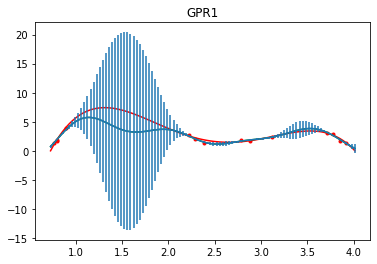

In [111]:
#KERNEL: exponential square kernel
def Kernel(x1,x2,params):
    amp = params[0]
    'How far should be between x1 and x2 for f(x1) to be uncorrelated with f(x2)'
    l = params[1]
    return amp**2 * np.exp(-((x1-x2)*(x1-x2))/(2*l**2))
X1, X2 = np.meshgrid(xd,xd)
X1st, X2st = np.meshgrid(x,x)
X1st2, X22 = np.meshgrid(x,xd)

#optimising kernel paramaters via marginal likelyhood
def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li+R@K@R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(yd.T@chol_inv(cov_li+R@K@R.T)@yd)                

x0=[3.15,0.096]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=200)
print('\n\nRESULTS',results)
best_params = results.x
# best_params = x0

print('\n\nMargLi',MargLi(best_params))

K = Kernel(X1,X2,best_params)
#add a small term onto diagonal of matricies to be inverted.
#this ensures it is positive definate and cholensky matrix can be computed
K[np.diag_indices_from(K)] += 1e-8 

Kstst = Kernel(X1st, X2st,best_params)
Kst = Kernel(X22, X1st2,best_params)
##Data Dist, has prior in it
mu_D = prior_mean_vector
cov_D = K + np.diag(np.repeat(exp_er,len(xd)))


print('Probably not good if 0. cov_D definetly cannot be 0 as it is inverted.')
# print('The Determinent of K is:', chol_det(K))
# print('The Determinent of Kst is:', chol_det(Kst))
# print('The Determinent of Kstst is:', chol_det(Kstst))
# print('The Determinent of cov_D is:', chol_det(cov_D))
##Predictions dist
mu_yst = np.repeat(0,N)
cov_yst = Kstst



cov_post1 = Kstst - Kst.T @ chol_inv(cov_D) @ Kst
mu_post1 = Kst.T @ chol_inv(cov_D) @ yd
error_bars1 = np.diagonal(cov_post1)


figGPR1 = plt.figure()
plt.title('GPR1')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
plt.plot(x,mu_post1,'g')
plt.errorbar(x, mu_post1, yerr=error_bars1)
plt.show()

In [88]:
import optuna

def objective(trial):
    amp = trial.suggest_float('amp', 0, 22)
    l = trial.suggest_float('l', 0, 4)
    params = [amp,l]
    return MargLi(params)
    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

study.best_params

[I 2023-07-24 15:31:16,446] A new study created in memory with name: no-name-ec0a98fb-dced-4150-91e1-c305b28659dc
[I 2023-07-24 15:31:16,459] Trial 0 finished with value: 1.7e+307 and parameters: {'amp': 20.712533630653894, 'l': 0.6671625444110578}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:31:16,465] Trial 1 finished with value: 1.7e+307 and parameters: {'amp': 7.5105263087546446, 'l': 1.892516166858767}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:31:16,471] Trial 2 finished with value: 1.7e+307 and parameters: {'amp': 8.912163510271387, 'l': 2.2969385740728883}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:31:16,478] Trial 3 finished with value: 1.7e+307 and parameters: {'amp': 5.528907926388603, 'l': 1.7494700167504402}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:31:16,489] Trial 4 finished with value: 1.7e+307 and parameters: {'amp': 6.18236321796653, 'l': 3.161907277815085}. Best is trial 0 with value: 1.7e+307.
[I 2023-07-24 15:31:16

[I 2023-07-24 15:31:17,942] Trial 44 finished with value: 17.502225707545787 and parameters: {'amp': 14.721900850557764, 'l': 0.0012392750039762167}. Best is trial 12 with value: 15.456191491576883.
[I 2023-07-24 15:31:17,990] Trial 45 finished with value: 1.7e+307 and parameters: {'amp': 11.178587182183191, 'l': 0.31426084342721383}. Best is trial 12 with value: 15.456191491576883.
[I 2023-07-24 15:31:18,036] Trial 46 finished with value: 1.7e+307 and parameters: {'amp': 13.226399425852545, 'l': 0.5955673083325095}. Best is trial 12 with value: 15.456191491576883.
[I 2023-07-24 15:31:18,080] Trial 47 finished with value: 1.7e+307 and parameters: {'amp': 14.08857133772797, 'l': 0.16471231065557124}. Best is trial 12 with value: 15.456191491576883.
[I 2023-07-24 15:31:18,127] Trial 48 finished with value: 1.7e+307 and parameters: {'amp': 11.804831476647173, 'l': 1.0682351145806679}. Best is trial 12 with value: 15.456191491576883.
[I 2023-07-24 15:31:18,166] Trial 49 finished with value

[I 2023-07-24 15:31:19,760] Trial 88 finished with value: 1.7e+307 and parameters: {'amp': 13.844057345596802, 'l': 0.10138147307848505}. Best is trial 86 with value: 15.26553788070669.
[I 2023-07-24 15:31:19,801] Trial 89 finished with value: 1.7e+307 and parameters: {'amp': 12.152727433322204, 'l': 0.494940720952805}. Best is trial 86 with value: 15.26553788070669.
[I 2023-07-24 15:31:19,841] Trial 90 finished with value: 1.7e+307 and parameters: {'amp': 13.289706920738945, 'l': 0.22873236807604092}. Best is trial 86 with value: 15.26553788070669.
[I 2023-07-24 15:31:19,879] Trial 91 finished with value: 15.227715708144768 and parameters: {'amp': 13.869560981762689, 'l': 0.08580620439772559}. Best is trial 91 with value: 15.227715708144768.
[I 2023-07-24 15:31:19,920] Trial 92 finished with value: 15.167874567728193 and parameters: {'amp': 13.592907661405805, 'l': 0.08428177804504182}. Best is trial 92 with value: 15.167874567728193.
[I 2023-07-24 15:31:19,960] Trial 93 finished with

[I 2023-07-24 15:31:21,647] Trial 131 finished with value: 14.531943726028246 and parameters: {'amp': 10.380389458422718, 'l': 0.05925018483659031}. Best is trial 120 with value: 13.128092303182925.
[I 2023-07-24 15:31:21,691] Trial 132 finished with value: 1.7e+307 and parameters: {'amp': 9.416936769793498, 'l': 0.1667392339715325}. Best is trial 120 with value: 13.128092303182925.
[I 2023-07-24 15:31:21,734] Trial 133 finished with value: 14.093414194426764 and parameters: {'amp': 10.438276750817915, 'l': 0.07135863028579138}. Best is trial 120 with value: 13.128092303182925.
[I 2023-07-24 15:31:21,785] Trial 134 finished with value: 15.425713079515141 and parameters: {'amp': 10.448556211929432, 'l': 0.01554190970210731}. Best is trial 120 with value: 13.128092303182925.
[I 2023-07-24 15:31:21,828] Trial 135 finished with value: 15.421056048460999 and parameters: {'amp': 10.431966363369211, 'l': 0.0026972680155813306}. Best is trial 120 with value: 13.128092303182925.
[I 2023-07-24 1

[I 2023-07-24 15:31:23,674] Trial 174 finished with value: 1.7e+307 and parameters: {'amp': 10.751622071992957, 'l': 1.183924793005538}. Best is trial 158 with value: 11.346281885958875.
[I 2023-07-24 15:31:23,735] Trial 175 finished with value: 13.799781172640976 and parameters: {'amp': 10.169616165746547, 'l': 0.07465861035902555}. Best is trial 158 with value: 11.346281885958875.
[I 2023-07-24 15:31:23,793] Trial 176 finished with value: 1.7e+307 and parameters: {'amp': 7.651534448612663, 'l': 0.22325092546469377}. Best is trial 158 with value: 11.346281885958875.
[I 2023-07-24 15:31:23,842] Trial 177 finished with value: 1.7e+307 and parameters: {'amp': 6.986659772719562, 'l': 0.13815376446769947}. Best is trial 158 with value: 11.346281885958875.
[I 2023-07-24 15:31:23,888] Trial 178 finished with value: 12.789562827533864 and parameters: {'amp': 8.431031688085845, 'l': 0.07231543490140757}. Best is trial 158 with value: 11.346281885958875.
[I 2023-07-24 15:31:23,929] Trial 179 fi

[I 2023-07-24 15:31:25,765] Trial 217 finished with value: 1.7e+307 and parameters: {'amp': 7.099732953858483, 'l': 1.9144277863574113}. Best is trial 211 with value: 10.206702004627276.
[I 2023-07-24 15:31:25,810] Trial 218 finished with value: 12.523439964060632 and parameters: {'amp': 6.0773580232952105, 'l': 0.004147810935617488}. Best is trial 211 with value: 10.206702004627276.
[I 2023-07-24 15:31:25,860] Trial 219 finished with value: 12.526347624954576 and parameters: {'amp': 6.081497955847076, 'l': 0.009978191002949853}. Best is trial 211 with value: 10.206702004627276.
[I 2023-07-24 15:31:25,910] Trial 220 finished with value: 12.55732381449073 and parameters: {'amp': 6.135657603565333, 'l': 0.016167964415750174}. Best is trial 211 with value: 10.206702004627276.
[I 2023-07-24 15:31:25,961] Trial 221 finished with value: 12.462651051645924 and parameters: {'amp': 5.99795300636557, 'l': 0.004381536257213617}. Best is trial 211 with value: 10.206702004627276.
[I 2023-07-24 15:3

[I 2023-07-24 15:31:27,996] Trial 260 finished with value: 1.7e+307 and parameters: {'amp': 4.981843461240842, 'l': 1.3658255301648057}. Best is trial 243 with value: 9.438809907787855.
[I 2023-07-24 15:31:28,046] Trial 261 finished with value: 1.7e+307 and parameters: {'amp': 4.495133671266275, 'l': 0.21336252504174824}. Best is trial 243 with value: 9.438809907787855.
[I 2023-07-24 15:31:28,093] Trial 262 finished with value: 1.7e+307 and parameters: {'amp': 5.0556733577980815, 'l': 0.12077736595371392}. Best is trial 243 with value: 9.438809907787855.
[I 2023-07-24 15:31:28,143] Trial 263 finished with value: 8.517618383963994 and parameters: {'amp': 4.088710770873708, 'l': 0.09124411709903801}. Best is trial 263 with value: 8.517618383963994.
[I 2023-07-24 15:31:28,192] Trial 264 finished with value: 1.7e+307 and parameters: {'amp': 3.8710026902466503, 'l': 0.23586510409540395}. Best is trial 263 with value: 8.517618383963994.
[I 2023-07-24 15:31:28,247] Trial 265 finished with val

[I 2023-07-24 15:31:30,330] Trial 304 finished with value: 1.7e+307 and parameters: {'amp': 4.292085306684499, 'l': 0.9030844850008953}. Best is trial 281 with value: 7.960346279980856.
[I 2023-07-24 15:31:30,397] Trial 305 finished with value: 1.7e+307 and parameters: {'amp': 3.357380184869389, 'l': 1.9996760110629368}. Best is trial 281 with value: 7.960346279980856.
[I 2023-07-24 15:31:30,459] Trial 306 finished with value: 1.7e+307 and parameters: {'amp': 4.1699369331958795, 'l': 1.6723750798077475}. Best is trial 281 with value: 7.960346279980856.
[I 2023-07-24 15:31:30,511] Trial 307 finished with value: 1.7e+307 and parameters: {'amp': 2.889297083035512, 'l': 0.2601112475567963}. Best is trial 281 with value: 7.960346279980856.
[I 2023-07-24 15:31:30,562] Trial 308 finished with value: 8.091891805581907 and parameters: {'amp': 3.6126406175042955, 'l': 0.09284388271849646}. Best is trial 281 with value: 7.960346279980856.
[I 2023-07-24 15:31:30,615] Trial 309 finished with value:

[I 2023-07-24 15:31:32,720] Trial 348 finished with value: 1.7e+307 and parameters: {'amp': 2.948126958512954, 'l': 1.1801007519215985}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:32,775] Trial 349 finished with value: 1.7e+307 and parameters: {'amp': 5.19233216856749, 'l': 0.10414176717552608}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:32,834] Trial 350 finished with value: 8.260671979221001 and parameters: {'amp': 3.85099613056553, 'l': 0.09318682910109127}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:32,890] Trial 351 finished with value: 1.7e+307 and parameters: {'amp': 0.35747535589802304, 'l': 0.19798232765434365}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:32,944] Trial 352 finished with value: 1.7e+307 and parameters: {'amp': 3.654184593081455, 'l': 1.8726883203745646}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:33,000] Trial 353 finished with value:

[I 2023-07-24 15:31:35,288] Trial 392 finished with value: 1.7e+307 and parameters: {'amp': 2.245532904055005, 'l': 0.09669200528583481}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:35,346] Trial 393 finished with value: 1.7e+307 and parameters: {'amp': 1.269915321926745, 'l': 0.3422749905127094}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:35,401] Trial 394 finished with value: 1.7e+307 and parameters: {'amp': 1.8771550856339816, 'l': 0.1617010849820677}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:35,455] Trial 395 finished with value: 1.7e+307 and parameters: {'amp': 1.4966347400994415, 'l': 1.0712487640672033}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:35,512] Trial 396 finished with value: 1.7e+307 and parameters: {'amp': 3.8323041010519496, 'l': 2.9266120295596014}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:35,574] Trial 397 finished with value: 9.48850

[I 2023-07-24 15:31:38,137] Trial 436 finished with value: 1.7e+307 and parameters: {'amp': 3.065327276414477, 'l': 1.4636083949842305}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:38,200] Trial 437 finished with value: 8.758441010617414 and parameters: {'amp': 2.6633133317685513, 'l': 0.06422842463088885}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:38,263] Trial 438 finished with value: 1.7e+307 and parameters: {'amp': 2.6400236888188857, 'l': 0.18965219773262723}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:38,323] Trial 439 finished with value: 8.943660828325562 and parameters: {'amp': 3.1881147132028587, 'l': 0.06305609874781708}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:38,384] Trial 440 finished with value: 1.7e+307 and parameters: {'amp': 3.155805696967564, 'l': 0.8640481825749697}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:38,444] Trial 441 finished

[I 2023-07-24 15:31:40,917] Trial 480 finished with value: 1.7e+307 and parameters: {'amp': 12.048329097987871, 'l': 0.5103100305823733}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:40,974] Trial 481 finished with value: 1.7e+307 and parameters: {'amp': 14.153363400128256, 'l': 0.14022936011669931}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:41,033] Trial 482 finished with value: 1.7e+307 and parameters: {'amp': 2.7665710285731246, 'l': 3.093118668176478}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:41,090] Trial 483 finished with value: 1.7e+307 and parameters: {'amp': 0.6665536590911487, 'l': 0.22570570411348553}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:41,154] Trial 484 finished with value: 9.229717495968469 and parameters: {'amp': 2.206916845324623, 'l': 0.0611791275065674}. Best is trial 314 with value: 7.732126081102348.
[I 2023-07-24 15:31:41,221] Trial 485 finished with valu

{'amp': 3.157841495145162, 'l': 0.09562287660324868}

## Before Kernel Optimisation

The performance is highly unstable. The errors vary from wildly large to extreamly tiny. The mean vector can look like gaussian noise or closely matching the profile. Also if the space between data points to too small the kernel covariance matric seems to have a determinent of 0 and thus no inverse. Some kernel parameters also cause this to hapen. It can happen in the other matracies aswell. This can cause errors in the code if the matrix is to be inveresed. It also causes the error bars to swing from almost infinity to almost 0. 

## After Kernel Optimisation

GP1 works extreamly well after kernel optimisation. Knowing exactly how the kernel parameters influence the graph can help dramatically for selecting a prior with optuna, or initial guesses for scipy.optimise(). The amp, sets how easy it is for the posterior mean to get far from the prior mean. The higher this is the weaker the prior is. The length scale l, sets how correlated two points are. For two points with one specific x distance apart, they are said to be more correlated is l is large and less correlated if l is small. We use how correlated they are in x as exactly how correlated they are in y.  

# Gaussian Process Regression 2
See notes, uses bayes theorum but must have the same x position for data and predictions. 

# Ignore this one for now

(14,)


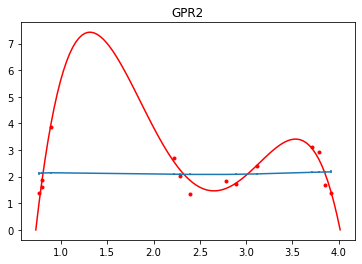

In [90]:
#exponential square kernel
def kernel(x1,x2):
    a = 10
    b = 10
    return a * np.exp(-((x1-x2)*(x1-x2))/b)
X1, X2 = np.meshgrid(xd,xd)
prior_cov = kernel(X1,X2) #np.diag(np.repeat(exp_er,len(x)))#
likelyhood_cov = np.diag(np.repeat(exp_er,len(xd)))
#Now we make the gaussian process distribution for the likelyhood
likelyhood = mnorm(mean=yd, cov=likelyhood_cov)
prior = mnorm(mean=np.repeat(0,len(xd)),cov=prior_cov, allow_singular=True)

#posterior_mean = inv(inv(prior_cov)+inv(likelyhood_cov)) @ (inv(prior_cov)@likelyhood.mean+inv(likelyhood_cov)@prior.mean)
posterior_mean = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood.mean  +  likelyhood_cov @ inv(prior_cov + likelyhood_cov) @ prior.mean
posterior_cov = prior_cov @ inv(prior_cov + likelyhood_cov) @ likelyhood_cov
error_bars2 = np.diagonal(posterior_cov)

print(np.shape(posterior_mean))
figGPR2 = plt.figure()
plt.title('GPR2')
plt.plot(x,y,'r')
plt.plot(xd,yd,'r.')
# plt.plot(x,posterior_mean,'g')
plt.errorbar(xd,posterior_mean, yerr=error_bars2)
plt.show()